<a href="https://cognitiveclass.ai"><img src = "https://ibm.box.com/shared/static/9gegpsmnsoo25ikkbl4qzlvlyjbgxs5x.png" width = 400> </a>

<h1 align=center><font size = 5>Capstone Project - The Battle of Neighborhoods</font></h1>


## Table of contents
* [1. Introduction](#introduction)
* [2. Data Preparation](#data)
  + [2a. import and cleanse census data](#census_data)
  + [2b. Get location coordinates of community areas](#geo)
  + [2c. Retrieve neighborhood venues of community areas](#venues)
* [3. Methodology](#methodology)
* [4. Data Analysis](#analysis)
  + [4a. Grouping Community Areas by Census Social Economic indices](#da_census)
  + [4b. Grouping Community Areas by Neighborhood Venues](#da_venus)
  + [4c. Correlate data from the two groupings](#da_correlate)
* [5. Results](#result)
* [6. Discussion](#discussion)
* [7. Conclusion](#conclusion)

## 1. Introduction <a name="introduction"></a>

This is the notebook dedicated for the **Capstone project – Battle of Neighborhoods**.  

In this study, we explore the community areas from two different perspectives: 
* Social economic indices, and 
* Neighborhood venues  

k-means clustering is performed on two sets of data – the latest census data for the community areas, and the neighborhood venue data retrieved using the FourSquare explore API.   

There are two major sections in this notebook:    
    
**Data Preparation:**    
In this section, we clean, retrieve and transform the data so that the datasets are ready for the analyzes.  

**Data Analysis:**   
In this section, we perform the clustering exercise and iterate with different k values to select the best k for both clustering dimensions. We also generate plots and maps and perform analysis in conjunction with manual data evaluation. 

The other sections, **methodology, results, discussions, ** and **conclusion**, are detailed in a separate report. The URL to the report is provided and the contents of these sections are **not** repeated here.


Download all the dependencies required.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.3


## 2. Data Preparation <a name="data"></a>

### 2a.  Import and cleanse census data  <a name="census_data"></a>

In [3]:
# read csv file with the census data for Chicago community areas
census_data = pd.read_csv("Census_Data_Chicago.csv")

In [4]:
print("dimension of data:", census_data.shape)
census_data.head()

dimension of data: (77, 9)


,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39
1,2,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46
2,3,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20
3,4,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17
4,5,North Center,0.3,7.5,5.2,4.5,26.2,57123,6


In [5]:
#Rename column "Community Area Name" as Neighborhood so that I can reuse the code used for previous assignment.
census_data.rename(columns={'COMMUNITY AREA NAME':'Neighborhood'}, inplace=True)

# also drop the column "Community Area Number" as it is not used in the analysis
census_data = census_data.drop('Community Area Number',1)
census_data.head()

,Neighborhood,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39
1,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46
2,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20
3,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17
4,North Center,0.3,7.5,5.2,4.5,26.2,57123,6


### 2b. Get location coordinates of community areas <a name = "geo"></a>

#### The geopy library is used to get the latitude and longitude values of city of Chicago as well as of the Chicago community areas.  


In [6]:
# get geo location of Chicago
address = 'Chicago, IL'

geolocator = Nominatim(user_agent="my_explorer")
location = geolocator.geocode(address)
chicago_lat = location.latitude
chicago_lon = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(chicago_lat, chicago_lon))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


In [7]:
# create a new dataframe that will have the neighborhood and location data
geo_data = census_data[['Neighborhood']].copy()

# initialize the location values
geo_data['Latitude'] = 0.0
geo_data['Longitude'] = 0.0
print ("Demension of geo_data", geo_data.shape)
geo_data.head()

Demension of geo_data (77, 3)


,Neighborhood,Latitude,Longitude
0,Rogers Park,0.0,0.0
1,West Ridge,0.0,0.0
2,Uptown,0.0,0.0
3,Lincoln Square,0.0,0.0
4,North Center,0.0,0.0


In [8]:
# get geo locations of the community areas
for i in range (0, geo_data.shape[0]):
    address = geo_data.loc[i,'Neighborhood'] + ' Chicago, IL'
   
    location = geolocator.geocode(address)
    if (location != None):
        geo_data.loc[i, 'Latitude']= location.latitude
        geo_data.loc[i, 'Longitude'] = location.longitude


In [9]:
# check if we've failed to get the location data for some neighborhoods
geo_data [geo_data['Latitude'] == 0.0].count() # we're good if the values are 0

Neighborhood    0
Latitude        0
Longitude       0
dtype: int64

In [10]:
geo_data.head()

,Neighborhood,Latitude,Longitude
0,Rogers Park,42.010531,-87.670748
1,West Ridge,42.003548,-87.696243
2,Uptown,41.966630,-87.655546
3,Lincoln Square,42.266997,-71.798432
4,North Center,41.956107,-87.679160


#### Create a map of Chicago  with neighborhoods superimposed on top.

In [11]:
# create map of Chicago using latitude and longitude values
map_chicago = folium.Map(location=[chicago_lat, chicago_lon], zoom_start=10)

# add markers to map showing the community areas
for lat, lng, neighborhood in zip(geo_data['Latitude'], geo_data['Longitude'], geo_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

### 2c. Retrieve neighborhood venues of community areas  <a name=venues></a>


#### To retrieve the neighborhood venues, the Foursquare API is used.

In [12]:

# Define FourSquare Credentials and versions
CLIENT_ID = 'CLN1QMOSO2WMBTVJXM5CB2TBBBBRWEHS4A3ZPI25C045K3ZJ' # your Foursquare ID
CLIENT_SECRET = 'CNFHFFSJUGT0JZQT5PSQB4ERRJQGRU13IMRICEP31O2X10VU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100
radius = 500
#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

<a id='item2'></a>

#### Define a function to repeat the same process for all the community areas to get the neighborhood venue data

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
   
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        print (name," - number of venues:", len(results))
       
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Calling the above function on each neighborhood and create a new dataframe called *chicago_venues* with the results from FourSquare queries

In [14]:
# type your answer here

chicago_venues = getNearbyVenues(names=geo_data['Neighborhood'],
                                   latitudes=geo_data['Latitude'],
                                   longitudes=geo_data['Longitude']
                                  )



Rogers Park  - number of venues: 33
West Ridge  - number of venues: 4
Uptown  - number of venues: 63
Lincoln Square  - number of venues: 33
North Center  - number of venues: 69
Lake View  - number of venues: 75
Lincoln Park  - number of venues: 72
Near North Side  - number of venues: 28
Edison Park  - number of venues: 27
Norwood Park  - number of venues: 3
Jefferson Park  - number of venues: 31
Forest Glen  - number of venues: 7
North Park  - number of venues: 5
Albany Park  - number of venues: 16
Portage Park  - number of venues: 22
Irving Park  - number of venues: 18
Dunning  - number of venues: 4
Montclare  - number of venues: 15
Belmont Cragin  - number of venues: 14
Hermosa  - number of venues: 12
Avondale  - number of venues: 34
Logan Square  - number of venues: 79
Humboldt park  - number of venues: 9
West Town  - number of venues: 33
Austin  - number of venues: 12
West Garfield Park  - number of venues: 19
East Garfield Park  - number of venues: 8
Near West Side  - number of ve

#### Check the size of the resulting dataframe; have a quick look at the data generated

In [15]:
print("dimentions of chicago_venues:", chicago_venues.shape)
chicago_venues.head()

dimentions of chicago_venues: (1615, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rogers Park,42.010531,-87.670748,El Famous Burrito,42.010421,-87.674204,Mexican Restaurant
1,Rogers Park,42.010531,-87.670748,Morse Fresh Market,42.008087,-87.667041,Grocery Store
2,Rogers Park,42.010531,-87.670748,Bark Place,42.010080,-87.675223,Pet Store
3,Rogers Park,42.010531,-87.670748,Taqueria & Restaurant Cd. Hidalgo,42.011634,-87.674484,Mexican Restaurant
4,Rogers Park,42.010531,-87.670748,The Common Cup,42.007797,-87.667901,Coffee Shop


In [16]:
# save the data in case one need to evaluate the individual venues in each community area
chicago_venues.to_csv("neighborhood_venues.csv")

Check how many venues were returned for each neighborhood

In [17]:
temp_df = chicago_venues.groupby('Neighborhood').count()

ca_venue_count = temp_df[['Venue']]
ca_venue_count = ca_venue_count.reset_index()

ca_venue_count = ca_venue_count.rename(columns={'Venue':'Venue_Count'})
ca_venue_count.to_csv("neighborhood_venue_count.csv")
ca_venue_count.head()


,Neighborhood,Venue_Count
0,Albany Park,16
1,Archer Heights,25
2,Armour Square,11
3,Ashburn,5
4,Auburn Gresham,7


In [18]:
#group by venue category for each community area
temp_df = chicago_venues.groupby(['Neighborhood','Venue Category']).count()
ca_category_count = temp_df[['Venue']]

ca_category_count = ca_category_count.reset_index()
ca_category_count = ca_category_count.rename(columns={"Venue": "Count"})
ca_category_count.to_csv("neighborhood_v_category_count.csv")
ca_category_count.head()

,Neighborhood,Venue Category,Count
0,Albany Park,Accessories Store,1
1,Albany Park,Bakery,1
2,Albany Park,Café,1
3,Albany Park,Chinese Restaurant,1
4,Albany Park,Cocktail Bar,1


#### Count how many unique categories are curated from all the returned venues

In [19]:
print('There are {} uniques categories.'.format(len(chicago_venues['Venue Category'].unique())))

There are 252 uniques categories.


In [20]:
#chek the types of venues in chicago area
chicago_venues['Venue Category'].unique()

array(['Mexican Restaurant', 'Grocery Store', 'Pet Store', 'Coffee Shop',
       'Farmers Market', 'Bar', 'Bakery', 'American Restaurant',
       'Deli / Bodega', 'Pizza Place', 'Chinese Restaurant',
       'Asian Restaurant', 'Diner', 'Sandwich Place', 'Sushi Restaurant',
       'Theater', 'Dive Bar', 'Breakfast Spot', 'Discount Store',
       'Train Station', 'Donut Shop', 'Performing Arts Venue', 'Park',
       'Fried Chicken Joint', 'Convenience Store', 'Bus Station',
       'Fast Food Restaurant', 'Climbing Gym', 'General Entertainment',
       'Vietnamese Restaurant', 'Ethiopian Restaurant', 'Tattoo Parlor',
       'Lounge', 'Music Venue', 'Jazz Club', 'Yoga Studio',
       'Big Box Store', 'Thai Restaurant', 'Concert Hall',
       'Mobile Phone Shop', 'Korean Restaurant', 'Wings Joint',
       'Salon / Barbershop', 'Bank', 'Smoke Shop', 'Automotive Shop',
       'Mediterranean Restaurant', 'Pharmacy', 'Bistro', 'Wine Bar',
       'New American Restaurant', 'Speakeasy', 'Hockey A

In [21]:
# check if there are neighborhoods that have no nearby venues
tdf = chicago_venues.groupby('Neighborhood').count()
tdf.shape

(76, 6)

##### Notes:
While there are 77 neighborhoods (i.e., community areas),  1 of them had no nearby venus. As a result, the dataframe grouped by 'Neighborhodd' has 76 unique locations.  This needs to be folded in when merging the dataframes later.

##### Perform one hot encoding on the neighborhood venue data retrieved using the FourSquare API. 
The "one hot" encoding converts each row in “Chicago_venues” into a new data frame that has columns for all the venue categories, and the venue category of the row is marked as “1” in the corresponding column.

In [22]:
# one hot encoding
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe - Note that "Neighborhood" is a category and there is alreay such a column
# I'm naming the new column NH_Name instead
chicago_onehot['Neighborhood'] = chicago_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]

print("Dimensions of chicago_onehot:", chicago_onehot.shape)
chicago_onehot.head()


Dimensions of chicago_onehot: (1615, 253)


,Neighborhood,ATM,Accessories Store,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Currency Exchange,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Exhibit,Eye Doctor,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Light Rail Station,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motel,Moving Target,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pub,Public Art,Record Shop,Recording Studio,Rental Car Location,Rental Service,Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Rogers Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

#### Next, group rows by neighborhood and taking the mean of the frequency of occurrence of each category

In [23]:
chicago_grouped = chicago_onehot.groupby('Neighborhood').mean().reset_index()
print("Demension of chicago_grouped:", chicago_grouped.shape)
chicago_grouped.head()

Demension of chicago_grouped: (76, 253)


,Neighborhood,ATM,Accessories Store,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Currency Exchange,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Exhibit,Eye Doctor,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Light Rail Station,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motel,Moving Target,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pub,Public Art,Record Shop,Recording Studio,Rental Car Location,Rental Service,Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Albany Park,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.00,0.0,0.0,0.062500,0.0,0.0,0.0625,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

#### The dataframes chicago_grouped is ready for use in data analysis in later sections of this notebook.

## 3. Methodology <a name=methodology></a>

Please see the **Methodology** section in the report at https://github.com/hlee-dsl/Coursera_Capstone/blob/master/Battle_of_Neighborhoods_Report.pdf for details. 

Basically, we use the *k-means* to cluster the community areas in chicago using both sets of data. In the census dataset, all the social economic indices are used as features; in the neighborhood venue dataset, all the venue categories are used as features. 

For the clustering exercise, we try different k's to select the value that allows us to best describe the clusters. Box plots are used for the first set while manual evaluation of the categories is used for the second set.

The clustering results from the two sets are also correlated to see if there are additional insights.


## 4. Data Analysis <a name=analysis></a>

### 4a. Grouping Community Areas by Census Social Economic indices <a name=da_census></a>


#### Firstly, examine the census data.

In [24]:
census_data.describe() 
 

,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,4.923377,21.766234,15.372727,20.341558,35.746753,25563.168831,49.506494
std,3.682887,11.529957,7.543412,11.823152,7.327716,15293.098259,28.690556
min,0.300000,3.300000,4.700000,2.500000,13.500000,8201.000000,1.000000
25%,2.300000,13.200000,9.200000,11.800000,32.000000,15754.000000,25.000000
50%,3.800000,18.900000,13.900000,18.500000,38.100000,21323.000000,50.000000
75%,6.800000,29.200000,20.000000,26.600000,40.500000,28887.000000,74.000000
max,15.800000,56.500000,35.900000,54.800000,51.500000,88669.000000,98.000000


In [25]:
# plot the data for per capita income since it's in a different scale
column_to_drop = ['PERCENT OF HOUSING CROWDED',
             'PERCENT HOUSEHOLDS BELOW POVERTY',
             'PERCENT AGED 16+ UNEMPLOYED',
             'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
             'PERCENT AGED UNDER 18 OR OVER 64',
                 'HARDSHIP INDEX']
income=census_data.copy()
income=income.drop(column_to_drop, axis=1)


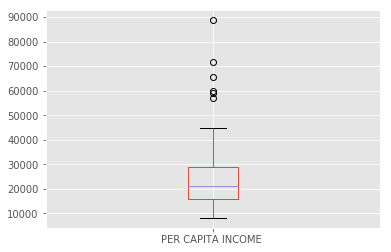

In [26]:
income.plot(kind='box')
plt.show()

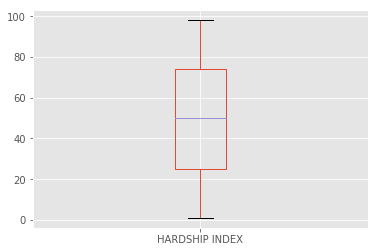

In [27]:
census_data['HARDSHIP INDEX'].plot(kind='box')
plt.show()

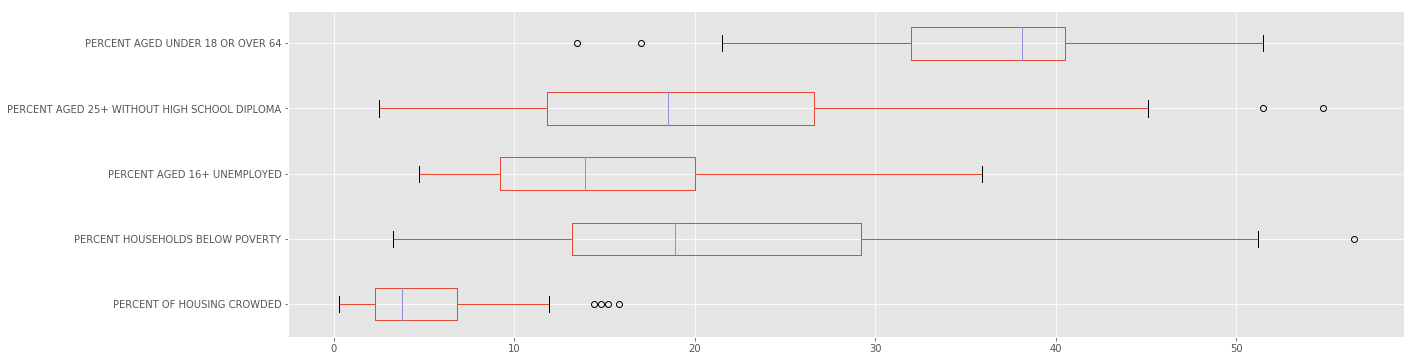

In [28]:
column_perc=['PERCENT OF HOUSING CROWDED',
             'PERCENT HOUSEHOLDS BELOW POVERTY',
             'PERCENT AGED 16+ UNEMPLOYED',
             'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
             'PERCENT AGED UNDER 18 OR OVER 64']
census_data[column_perc].plot(kind='box',figsize=(20, 6), vert=False)

plt.show()

#### next, run *k*-means to cluster the neighborhood into 4 clusters based on the social economic data.
Please note that below we use k=4 for the final result. However, we've tried many different k values using the same code segments and have concluded that k=4 is a value that make the best sense.

In [29]:
# set number of clusters/groups
kclusters = 4

chicago_census_clustering = census_data.drop('Neighborhood', 1)
#chicago_census_clustering.head()

# run k-means clustering
census_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_census_clustering)

# check cluster labels generated for each row in the dataframe
census_kmeans.labels_[0:5] 

array([0, 0, 3, 3, 2])

In [30]:
# add label back to the original data
census_clust = census_data.copy()

census_clust.insert(1,'Census_Group', census_kmeans.labels_)
census_clust.head()

,Neighborhood,Census_Group,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,Rogers Park,0,7.7,23.6,8.7,18.2,27.5,23939,39
1,West Ridge,0,7.8,17.2,8.8,20.8,38.5,23040,46
2,Uptown,3,3.8,24.0,8.9,11.8,22.2,35787,20
3,Lincoln Square,3,3.4,10.9,8.2,13.4,25.5,37524,17
4,North Center,2,0.3,7.5,5.2,4.5,26.2,57123,6


Let's examine the clusters using the mean value of different social economic indices

In [31]:
# see group/cluster sizes
census_group_count = census_clust.groupby('Census_Group').count()
census_group_count = census_group_count[['Neighborhood']]
census_group_count

,Neighborhood
Census_Group,
0,25
1,33
2,6
3,13


In [32]:
# Add descriptions to the stats
census_groups = census_clust.groupby('Census_Group').median().round(2)
census_groups

,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
Census_Group,,,,,,,
0,3.3,15.4,12.40,17.70,37.60,23791,41
1,6.8,29.0,19.40,27.60,40.30,15089,76
2,1.2,12.6,5.15,3.35,21.65,62792,4
3,2.3,14.7,8.40,9.70,26.20,37524,16


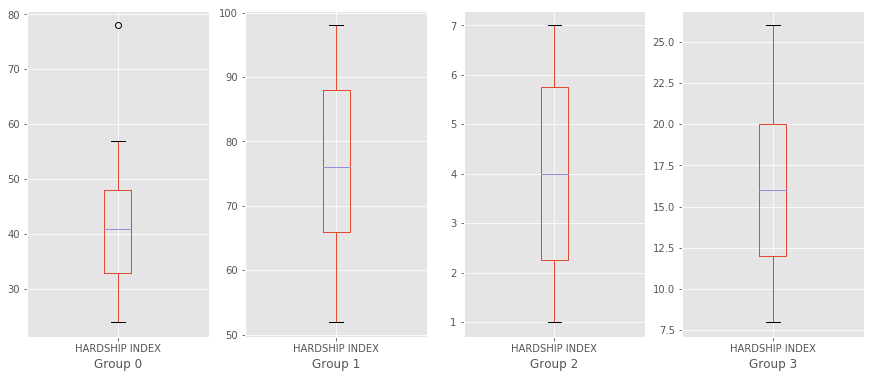

In [33]:
fig = plt.figure() # initialize the figure
for i in range(kclusters):
    ax_i = fig.add_subplot(1, kclusters, i+1)
    label = "Group " + str(i)
    ax_i.set_xlabel(label)
    census_clust[census_clust['Census_Group']==i]['HARDSHIP INDEX'].plot(kind='box', figsize=(15,6),ax=ax_i)
    
plt.show()


In [34]:
# plot the data for per capita income since it's in a different scale
column_to_drop = ['PERCENT OF HOUSING CROWDED',
             'PERCENT HOUSEHOLDS BELOW POVERTY',
             'PERCENT AGED 16+ UNEMPLOYED',
             'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
             'PERCENT AGED UNDER 18 OR OVER 64',
                 'HARDSHIP INDEX']
income=census_clust.copy()
income=income.drop(column_to_drop, axis=1)

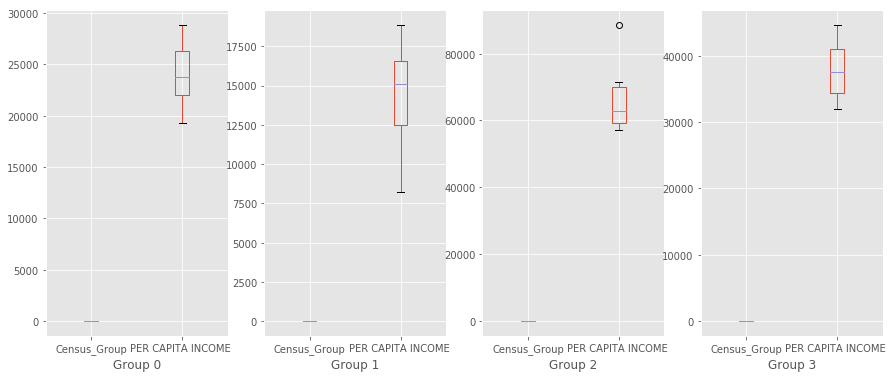

In [35]:
fig = plt.figure() # initialize the figure
for i in range(kclusters):
    ax_i = fig.add_subplot(1, kclusters, i+1)
    label = "Group " + str(i)
    ax_i.set_xlabel(label)
    income[income['Census_Group']==i].plot(kind='box', figsize=(15,6),ax=ax_i)

plt.show()


PERCENT OF HOUSING CROWDED


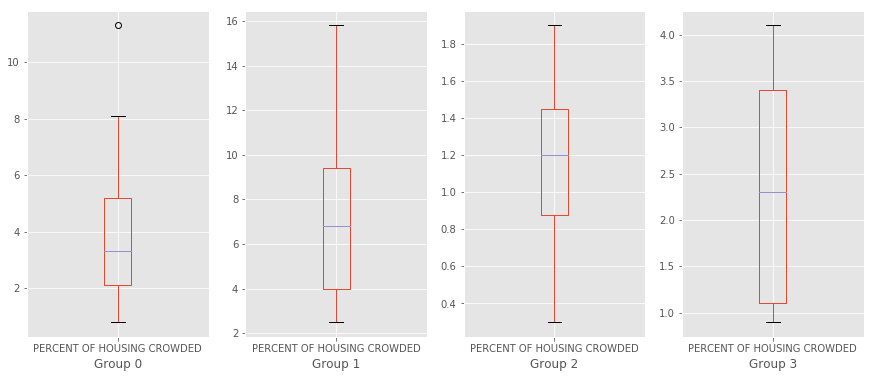

PERCENT HOUSEHOLDS BELOW POVERTY


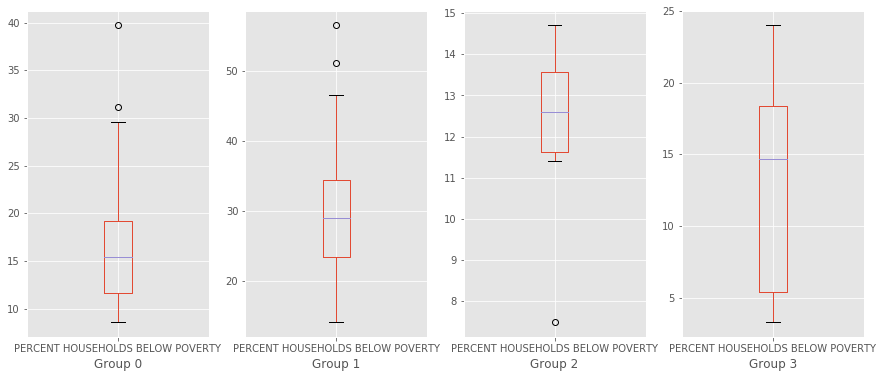

PERCENT AGED 16+ UNEMPLOYED


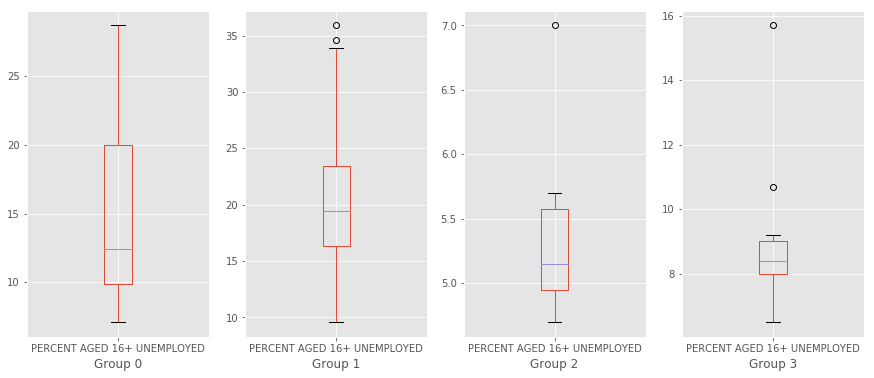

PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA


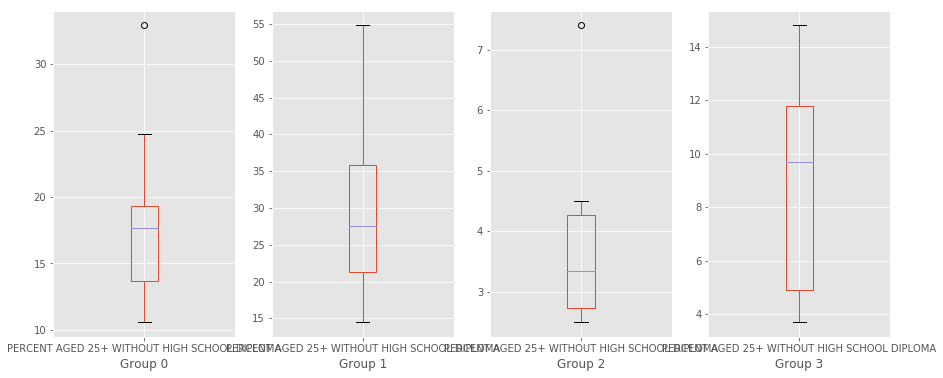

PERCENT AGED UNDER 18 OR OVER 64


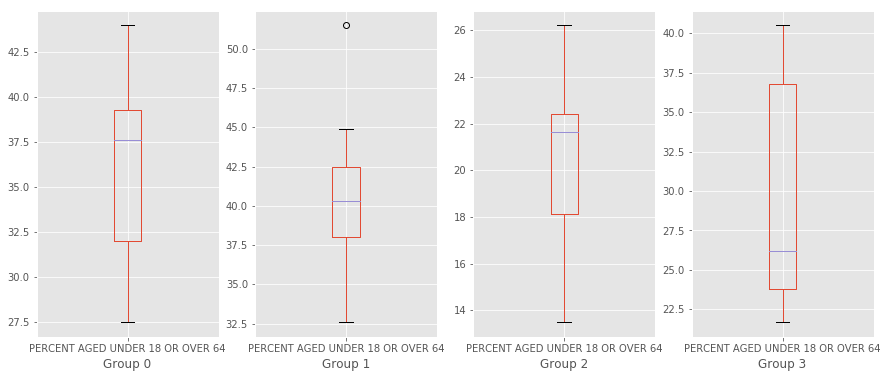

In [36]:
column_perc=['PERCENT OF HOUSING CROWDED',
             'PERCENT HOUSEHOLDS BELOW POVERTY',
             'PERCENT AGED 16+ UNEMPLOYED',
             'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
             'PERCENT AGED UNDER 18 OR OVER 64']

for col in column_perc:
    print(col)
    fig = plt.figure() # create a new figure
    for i in range(kclusters):
        ax_i = fig.add_subplot(1, kclusters, i+1)
        label = "Group " + str(i)
        ax_i.set_xlabel(label)
        census_clust[census_clust['Census_Group']==i][col].plot(kind='box', labels=None, figsize=(15,6),ax=ax_i)
    plt.show()



In [37]:
# add geo location data
census_merged = geo_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
census_merged = census_merged.join(census_clust.set_index('Neighborhood'), on='Neighborhood')


#census_merged.head() # check the last columns!

#### Show the census groups on the map

In [38]:
# create map
map_clusters = folium.Map(location=[chicago_lat, chicago_lon], zoom_start=11)


number_colors = 2*kclusters+1

# set color scheme for the clusters
x = np.arange(number_colors)
ys = [i + x + (i*x)**2 for i in range(number_colors)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers for the census cluster
inc = kclusters+1
for lat, lon, poi, cluster in zip(census_merged['Latitude'], census_merged['Longitude'], census_merged['Neighborhood'], census_merged['Census_Group']):
    label = folium.Popup(str(poi) + ' Census Group ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[inc+cluster-1],
        fill=True,
        fill_color=rainbow[inc+cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 4b. Grouping Community Areas by Neighborhood Venues <a name=da_venus></a>

#### Let's print each neighborhood along with the top 5 most common venues

In [39]:
num_top_venues = 5

for hood in chicago_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = chicago_grouped[chicago_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Albany Park----
                 venue  freq
0       Sandwich Place  0.12
1               Bakery  0.06
2  Fried Chicken Joint  0.06
3        Grocery Store  0.06
4         Cocktail Bar  0.06


----Archer Heights----
                venue  freq
0   Mobile Phone Shop  0.12
1  Mexican Restaurant  0.12
2                Park  0.08
3         Gas Station  0.08
4       Grocery Store  0.08


----Armour Square----
                venue  freq
0  Chinese Restaurant  0.27
1       Hot Dog Joint  0.09
2    Asian Restaurant  0.09
3  Italian Restaurant  0.09
4         Gas Station  0.09


----Ashburn----
                        venue  freq
0              Cosmetics Shop   0.2
1           Electronics Store   0.2
2  Construction & Landscaping   0.2
3          Italian Restaurant   0.2
4          Light Rail Station   0.2


----Auburn Gresham----
                  venue  freq
0  Fast Food Restaurant  0.29
1              Pharmacy  0.14
2                Lounge  0.14
3        Discount Store  0.14
4      Greek

               venue  freq
0              Track  0.17
1  Convenience Store  0.17
2          BBQ Joint  0.17
3      Train Station  0.17
4               Park  0.17


----Mount Greenwood----
            venue  freq
0  Cosmetics Shop  0.33
1            Park  0.33
2        Vineyard  0.33
3   National Park  0.00
4          Office  0.00


----Near North Side----
                  venue  freq
0  Gym / Fitness Center  0.11
1            Restaurant  0.07
2                   Gym  0.07
3           Coffee Shop  0.07
4           Yoga Studio  0.07


----Near South Side----
         venue  freq
0         Park  0.06
1  Coffee Shop  0.04
2          Bar  0.04
3  Pizza Place  0.04
4         Bank  0.04


----Near West Side----
                 venue  freq
0           Donut Shop  0.08
1           Sports Bar  0.08
2            Gastropub  0.04
3  Fried Chicken Joint  0.04
4     Basketball Court  0.04


----New City----
                        venue  freq
0         American Restaurant  0.13
1         Fried Chic

#### Construct a new  *pandas* dataframe and preparing for clustering

In [40]:
#firstly, define a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Next, run *k*-means to cluster the neighborhood into 5 clusters based on the venues retrieved.

In [41]:
# next, create the new data frame and display the top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_base = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_base['Neighborhood'] = chicago_grouped['Neighborhood']

for ind in np.arange(chicago_grouped.shape[0]):
    neighborhoods_venues_sorted_base.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_base.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Sandwich Place,Chinese Restaurant,Fried Chicken Joint,Accessories Store,Hookah Bar,Pizza Place,Korean Restaurant,Bakery,Mobile Phone Shop,Karaoke Bar
1,Archer Heights,Mexican Restaurant,Mobile Phone Shop,Park,Grocery Store,Gas Station,Candy Store,Bar,Video Store,Gym / Fitness Center,Wings Joint
2,Armour Square,Chinese Restaurant,Breakfast Spot,Italian Restaurant,Hot Dog Joint,Cosmetics Shop,Gas Station,Sports Bar,Sandwich Place,Asian Restaurant,Electronics Store
3,Ashburn,Cosmetics Shop,Construction & Landscaping,Electronics Store,Light Rail Station,Italian Restaurant,Fabric Shop,Ethiopian Restaurant,Exhibit,Eye Doctor,Farm
4,Auburn Gresham,Fast Food Restaurant,Cosmetics Shop,Greek Restaurant,Pharmacy,Discount Store,Lounge,Eye Doctor,Electronics Store,Ethiopian Restaurant,Exhibit


#### next, run *k*-means to cluster the neighborhood into 3 clusters based on the neighborhood venue data.
Again, note that below we use k=3 for the final result. However, we've tried many different k values using the same code segments and have concluded that k=3 is a value that make the best sense.


In [42]:
# set number of clusters
kclusters = 3

chicago_grouped_clustering = chicago_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100] 

array([2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 1, 1, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 1, 2, 1, 2, 1, 2, 2,
       0, 2, 1, 2, 2, 1, 2, 2, 2, 0])

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [43]:
# create a new copy so we can iterate with different k
neighborhoods_venues_sorted = neighborhoods_venues_sorted_base.copy()

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

chicago_merged = geo_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
chicago_merged =chicago_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


chicago_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Rogers Park,42.010531,-87.670748,1.0,Mexican Restaurant,Pizza Place,Bakery,Chinese Restaurant,Theater,Train Station,Performing Arts Venue,Coffee Shop,Sandwich Place,Donut Shop
1,West Ridge,42.003548,-87.696243,2.0,Convenience Store,Fried Chicken Joint,Bus Station,Donut Shop,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market
2,Uptown,41.966630,-87.655546,2.0,Coffee Shop,Mexican Restaurant,Pizza Place,Chinese Restaurant,Sushi Restaurant,Diner,Sandwich Place,Ethiopian Restaurant,Lounge,Convenience Store
3,Lincoln Square,42.266997,-71.798432,2.0,American Restaurant,Sandwich Place,Café,Donut Shop,New American Restaurant,Yoga Studio,Coffee Shop,Mexican Restaurant,Bistro,Speakeasy
4,North Center,41.956107,-87.679160,2.0,Bar,Coffee Shop,Brewery,Theater,Gym / Fitness Center,Boutique,Salon / Barbershop,Video Store,Bank,Dive Bar


Notes:
Remember there is 1 neighborhood that has no nearby venues? it is not included in the clustering and the cluste label has 
 a NaN value. As a result, the join made the reset of the values as float instead of int.

Below I put kcluster as a new class (so we have 1 additional clusters!)  and convert the label value to integer. Integer is required since we use the cluster labels to select map colors

Finally, let's visualize the resulting clusters

In [44]:
yet_another_cluster = kclusters 
chicago_merged['Cluster_Labels'].fillna(yet_another_cluster, inplace=True)
chicago_merged['Cluster_Labels'] = chicago_merged['Cluster_Labels'].astype('int32')


In [45]:
# see group/cluster sizes
cluster_count = chicago_merged.groupby('Cluster_Labels').count()
cluster_count = cluster_count[['Neighborhood']]
cluster_count

,Neighborhood
Cluster_Labels,
0,15
1,10
2,51
3,1


#### show the clusters based on venus in the map

In [46]:
# create map
map_clusters = folium.Map(location=[chicago_lat, chicago_lon], zoom_start=11)

# there are kclusters in each clustering exercise, we also have an extra color needed for the neighborhood that
# has no nearby venues
number_colors = kclusters+1

# set color scheme for the clusters
x = np.arange(number_colors)
ys = [i + x + (i*x)**2 for i in range(number_colors)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map for the venue cluster
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Neighborhood'], chicago_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

#### Take a closer look at the neighborhood clusters based on the nearby venues

#### Cluster 0

In [47]:
chicago_merged.loc[chicago_merged['Cluster_Labels'] == 0, chicago_merged.columns[[0] + list(range(5, chicago_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Norwood Park,Campground,Dog Run,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Farm,Fabric Shop,Eye Doctor
12,North Park,Gymnastics Gym,Nature Preserve,Park,Scenic Lookout,Farm,Fabric Shop,Eye Doctor,Farmers Market,Dog Run
16,Dunning,Bar,Park,Deli / Bodega,Fabric Shop,Electronics Store,Ethiopian Restaurant,Exhibit,Eye Doctor,Yoga Studio
22,Humboldt park,Lake,Café,Food Truck,Soccer Field,Museum,Yoga Studio,Electronics Store,Ethiopian Restaurant,Exhibit
24,Austin,Park,Shoe Repair,Train Station,Wings Joint,Japanese Restaurant,Liquor Store,Donut Shop,Gym,Grocery Store
35,Oakland,Boutique,Track,Discount Store,Lake,Public Art,Fast Food Restaurant,Farmers Market,Farm,Fabric Shop
36,Fuller Park,Sandwich Place,Intersection,Park,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Exhibit
41,Woodlawn,Coffee Shop,Garden,Yoga Studio,Eye Doctor,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Exhibit,Fabric Shop
43,Chatham,Fast Food Restaurant,Park,Bus Station,Yoga Studio,Fish & Chips Shop,Filipino Restaurant,Farmers Market,Farm,Fabric Shop
47,Calumet Heights,Park,Gym / Fitness Center,Bus Station,Yoga Studio,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Exhibit


#### Cluster 1

In [48]:
chicago_merged.loc[chicago_merged['Cluster_Labels'] == 1, chicago_merged.columns[[0] + list(range(5, chicago_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Rogers Park,Pizza Place,Bakery,Chinese Restaurant,Theater,Train Station,Performing Arts Venue,Coffee Shop,Sandwich Place,Donut Shop
18,Belmont Cragin,Grocery Store,Department Store,Bakery,Nightclub,Thrift / Vintage Store,Chinese Restaurant,Discount Store,Pharmacy,BBQ Joint
29,South Lawndale,Pizza Place,Park,Liquor Store,Discount Store,Dessert Shop,Grocery Store,Restaurant,Bank,Mobile Phone Shop
30,Lower West Side,Bakery,Pizza Place,Thrift / Vintage Store,Dessert Shop,Breakfast Spot,Taco Place,Fried Chicken Joint,Supermarket,Latin American Restaurant
45,South Chicago,Convenience Store,Grocery Store,Park,Music Store,Italian Restaurant,Train Station,Discount Store,Bakery,Farmers Market
55,Garfield Ridge,Discount Store,Parking,Mobile Phone Shop,Gas Station,Paper / Office Supplies Store,Park,Sandwich Place,Department Store,Dry Cleaner
57,Brighton Park,Pizza Place,Grocery Store,Taco Place,Bus Station,Breakfast Spot,Check Cashing Service,Café,Burger Joint,Park
61,West Elsdon,Gym / Fitness Center,Flea Market,Fast Food Restaurant,Fried Chicken Joint,Supermarket,Gas Station,Bar,Bakery,Grocery Store
62,Gage Park,Construction & Landscaping,Asian Restaurant,Currency Exchange,Sandwich Place,Bakery,Convenience Store,Health & Beauty Service,Donut Shop,Filipino Restaurant
64,West Lawn,Seafood Restaurant,Bowling Alley,Diner,Fast Food Restaurant,Shopping Mall,Bank,Bakery,Sandwich Place,Discount Store


#### Cluster 2

In [49]:
chicago_merged.loc[chicago_merged['Cluster_Labels'] == 2, chicago_merged.columns[[0] + list(range(5, chicago_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,West Ridge,Fried Chicken Joint,Bus Station,Donut Shop,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market
2,Uptown,Mexican Restaurant,Pizza Place,Chinese Restaurant,Sushi Restaurant,Diner,Sandwich Place,Ethiopian Restaurant,Lounge,Convenience Store
3,Lincoln Square,Sandwich Place,Café,Donut Shop,New American Restaurant,Yoga Studio,Coffee Shop,Mexican Restaurant,Bistro,Speakeasy
4,North Center,Coffee Shop,Brewery,Theater,Gym / Fitness Center,Boutique,Salon / Barbershop,Video Store,Bank,Dive Bar
5,Lake View,Sports Bar,General Entertainment,Sandwich Place,Pizza Place,Baseball Stadium,Mexican Restaurant,Sporting Goods Shop,BBQ Joint,Dive Bar
6,Lincoln Park,Pizza Place,Bar,Coffee Shop,Breakfast Spot,Fast Food Restaurant,Cosmetics Shop,Taco Place,Mexican Restaurant,Art Gallery
7,Near North Side,Yoga Studio,Coffee Shop,Gym,Restaurant,Breakfast Spot,Massage Studio,Lounge,Beer Bar,French Restaurant
8,Edison Park,Italian Restaurant,Pizza Place,American Restaurant,Mexican Restaurant,Deli / Bodega,Bakery,Theater,Liquor Store,Dessert Shop
10,Jefferson Park,Coffee Shop,Eastern European Restaurant,Pharmacy,Video Store,Theater,Park,Filipino Restaurant,Sandwich Place,Bus Station
11,Forest Glen,Fast Food Restaurant,Moving Target,Indian Restaurant,Golf Course,Coffee Shop,Grocery Store,Ethiopian Restaurant,Dry Cleaner,Eastern European Restaurant


#### Cluster 3
This is the extra cluster with the community area that does not have any neighborhood venues.

In [50]:
chicago_merged.loc[chicago_merged['Cluster_Labels'] == 3, chicago_merged.columns[[0] + list(range(5, chicago_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,Riverdale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  4c. Correlate data from the two groupings <a name=da_correlate></a>

First of all, let's plot the groups/clusters on the same map


In [53]:
# create map
map_clusters = folium.Map(location=[chicago_lat, chicago_lon], zoom_start=11)

# there are kclusters in each clustering exercise, we also have an extra color needed for the neighborhood that
# has no nearby venues
number_colors = 2*kclusters+1 

# set color scheme for the clusters
x = np.arange(number_colors)
ys = [i + x + (i*x)**2 for i in range(number_colors)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map for the venue cluster
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Neighborhood'], chicago_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

# add markers for the census cluster
inc = kclusters+1
for lat, lon, poi, cluster in zip(census_merged['Latitude'], census_merged['Longitude'], census_merged['Neighborhood'], census_merged['Census_Group']):
    label = folium.Popup(str(poi) + ' Census Group ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[inc+cluster-1],
        fill=False,
        fill_color=rainbow[inc+cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### it is not very easy to see the correlations on the map. 

Let's try putting the census grouping and neighborhood clustering in the same dataframe:

In [54]:
venue_clust = chicago_merged[['Neighborhood','Cluster_Labels']]
venue_clust.head()

,Neighborhood,Cluster_Labels
0,Rogers Park,1
1,West Ridge,2
2,Uptown,2
3,Lincoln Square,2
4,North Center,2


In [55]:
census_group = census_merged[['Neighborhood','Census_Group']]
census_group.head()


,Neighborhood,Census_Group
0,Rogers Park,0
1,West Ridge,0
2,Uptown,3
3,Lincoln Square,3
4,North Center,2


In [56]:
combined_data = venue_clust.copy()
combined_data = combined_data.join(
    census_group.set_index('Neighborhood'), 
    on='Neighborhood')
combined_data.head(10)

,Neighborhood,Cluster_Labels,Census_Group
0,Rogers Park,1,0
1,West Ridge,2,0
2,Uptown,2,3
3,Lincoln Square,2,3
4,North Center,2,2
5,Lake View,2,2
6,Lincoln Park,2,2
7,Near North Side,2,2
8,Edison Park,2,3
9,Norwood Park,0,3


In [57]:
df=combined_data.groupby(['Cluster_Labels','Census_Group']).count()
df.reset_index()
df.rename(columns={'Neighborhood': 'Count'}, inplace=True)
df.head()

Count
Cluster_Labels Census_Group       
0              0                 8
               1                 5
               3                 2
1              0                 2
               1                 8

In [58]:
df.reset_index(inplace=True)

In [59]:
weight = df['Count']
weight

0     8
1     5
2     2
3     2
4     8
5    15
6    19
7     6
8    11
9     1
Name: Count, dtype: int64

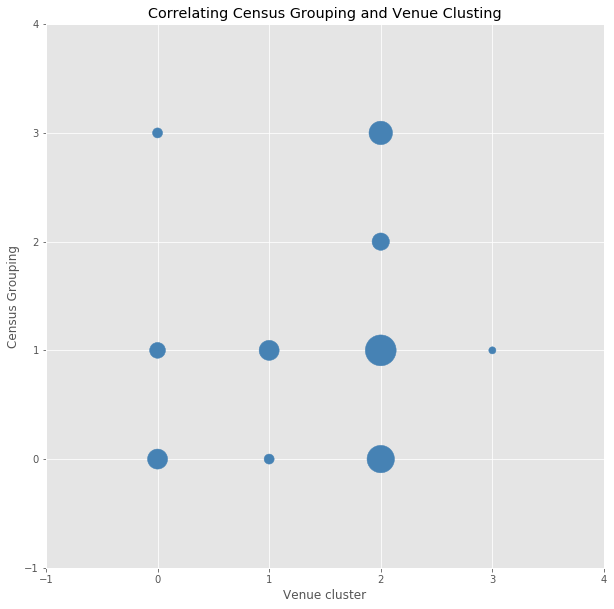

In [60]:
#draw a bubble chart
df.plot(kind='scatter', 
        x='Cluster_Labels', 
        y='Census_Group', 
        s=weight*50,
        figsize=(10,10),
        xlim=(-1,4),
        ylim=(-1,4),
        color='steelblue')

plt.title('Correlating Census Grouping and Venue Clusting')
plt.xlabel('Venue cluster')
plt.ylabel('Census Grouping')

plt.show()

## 5. Results <a name=result></a>

Please see the **Analysis Results** section in the report at https://github.com/hlee-dsl/Coursera_Capstone/blob/master/Battle_of_Neighborhoods_Report.pdf for details on what each group/cluster mean, and why we choose the particular k values.

## 6. Discussions <a name=discussion></a>

Please see the **Discussions** section in the report at https://github.com/hlee-dsl/Coursera_Capstone/blob/master/Battle_of_Neighborhoods_Report.pdf for details on how to interpret and how to use the results of this data analysis.

## 7. Conclusion <a name=conclusion></a>

Please see the **Conclusion** section in the report at https://github.com/hlee-dsl/Coursera_Capstone/blob/master/Battle_of_Neighborhoods_Report.pdf for details.